In [ ]:
# Install required libraries if not already installed
import sys
import subprocess

def install_if_missing(packages):
    for package in packages:
        try:
            __import__(package)
        except ImportError:
            subprocess.check_call([sys.executable, "-m", "pip", "install", package])

install_if_missing(["numpy", "pandas", "matplotlib", "seaborn", "tensorflow", "scikit-learn", "opencv-python"])

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import cv2

DATASET_PATH = r"E:\Projects\PneuScan\chest_xray"
if os.path.exists(DATASET_PATH):
    print("Dataset found ✅")
    print("Contents:", os.listdir(DATASET_PATH))
else:
    print("❌ Dataset not found. Check the path!")

In [ ]:
# Data loading and preprocessing pipeline
labels = ['NORMAL', 'PNEUMONIA']  # NORMAL=0, PNEUMONIA=1

def get_images_and_labels(data_dir, img_size=150):
    images, labels_list = [], []
    class_names = ['NORMAL', 'PNEUMONIA']
    for i, label in enumerate(class_names):
        path = os.path.join(data_dir, label)
        if not os.path.isdir(path):
            continue
        for img_name in os.listdir(path):
            try:
                img_path = os.path.join(path, img_name)
                img_arr = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img_arr is None:
                    continue
                img_resized = cv2.resize(img_arr, (img_size, img_size))
                images.append(img_resized)
                labels_list.append(i)
            except Exception:
                continue
    return np.array(images), np.array(labels_list)

# Load all data
train_images, train_labels = get_images_and_labels(os.path.join(DATASET_PATH, 'train'))
test_images, test_labels = get_images_and_labels(os.path.join(DATASET_PATH, 'test'))
val_images, val_labels = get_images_and_labels(os.path.join(DATASET_PATH, 'valid'))

# Combine and split for robust test/val/train
all_images = np.concatenate([train_images, test_images, val_images], axis=0)
all_labels = np.concatenate([train_labels, test_labels, val_labels], axis=0)

x_temp, x_test, y_temp, y_test = train_test_split(all_images, all_labels, test_size=0.2, random_state=42, stratify=all_labels)
x_train, x_val, y_train, y_val = train_test_split(x_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp)

# Normalize and reshape
x_train = x_train.astype('float32') / 255.0
x_val = x_val.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = x_train.reshape(-1, 150, 150, 1)
x_val = x_val.reshape(-1, 150, 150, 1)
x_test = x_test.reshape(-1, 150, 150, 1)

print(f"Train: {x_train.shape}, Val: {x_val.shape}, Test: {x_test.shape}")

In [ ]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_datagen.fit(x_train)

In [ ]:
# Compute class weights
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}
print("Class weights:", class_weights_dict)

In [ ]:
# Model definition
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1), padding='same'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.2),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

In [ ]:
# Pruning and model simplification
!pip install -q tensorflow-model-optimization
import tensorflow_model_optimization as tfmot

# Define a smaller, pruned model
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
        initial_sparsity=0.5, final_sparsity=0.8,
        begin_step=0, end_step=1000)
}

pruned_model = Sequential([
    prune_low_magnitude(Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 1), padding='same'), **pruning_params),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),
    prune_low_magnitude(Conv2D(32, (3, 3), activation='relu', padding='same'), **pruning_params),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.2),
    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

pruned_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Pruning callback
pruning_callbacks = callbacks + [tfmot.sparsity.keras.UpdatePruningStep()]

# Train pruned model
pruned_history = pruned_model.fit(
    train_datagen.flow(x_train, y_train, batch_size=32),
    epochs=15,
    validation_data=(x_val, y_val),
    class_weight=class_weights_dict,
    callbacks=pruning_callbacks,
    verbose=1
)

# Strip pruning wrappers and save smaller model
final_model = tfmot.sparsity.keras.strip_pruning(pruned_model)
final_model.save('pruned_pneumonia_model.h5')
print('Pruned model saved as pruned_pneumonia_model.h5')

In [ ]:
# Callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
callbacks = [
    ModelCheckpoint('best_pneumonia_model.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
]

In [37]:
# Model training
history = model.fit(
    train_datagen.flow(x_train, y_train, batch_size=32),
    epochs=30,
    validation_data=(x_val, y_val),
    class_weight=class_weights_dict,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30


c:\Users\ASUS\.conda\envs\GPUT\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 5/93 ━━━━━━━━━━━━━━━━━━━━ 32s 373ms/step - accuracy: 0.9204 - loss: 0.2783 - precision_3: 0.9524 - recall_3: 0.9230

KeyboardInterrupt: 

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.9227 - loss: 0.1840 - precision_3: 0.9667 - recall_3: 0.9165
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.9227 - loss: 0.1840 - precision_3: 0.9667 - recall_3: 0.9165
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.86      0.94      0.90       317
   PNEUMONIA       0.97      0.92      0.95       609

    accuracy                           0.93       926
   macro avg       0.92      0.93      0.92       926
weighted avg       0.93      0.93      0.93       926


Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.86      0.94      0.90       317
   PNEUMONIA       0.97      0.92      0.95       609

    accuracy                           0.93       926
   macro avg       0.92      0.93      0.92       926
weighted avg       0.93      0.93      0.93

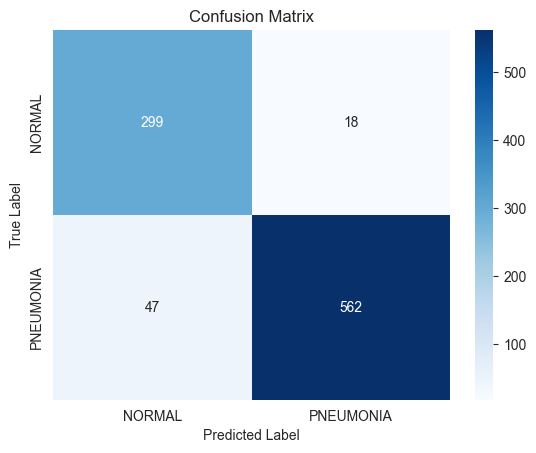

In [38]:
# Model evaluation
results = model.evaluate(x_test, y_test)
y_pred_prob = model.predict(x_test)
y_pred = (y_pred_prob > 0.5).astype(int)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['NORMAL', 'PNEUMONIA']))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

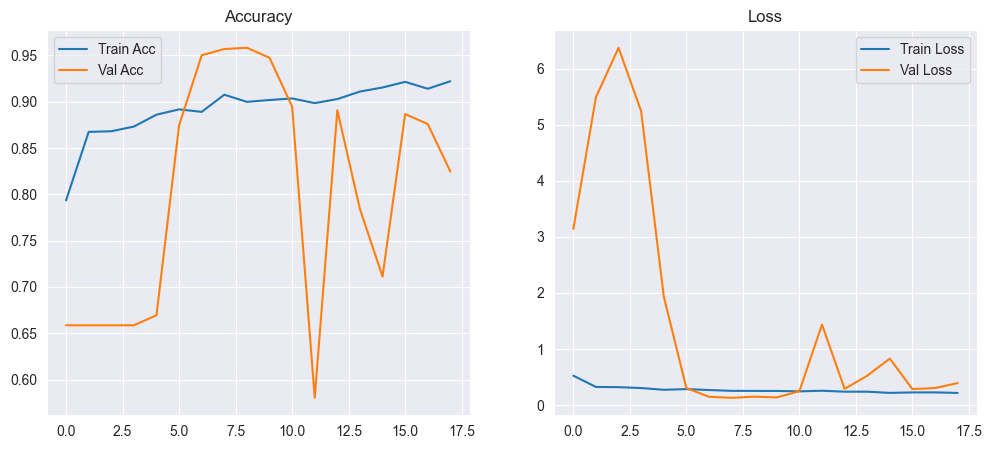

In [39]:
# Training and validation curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()

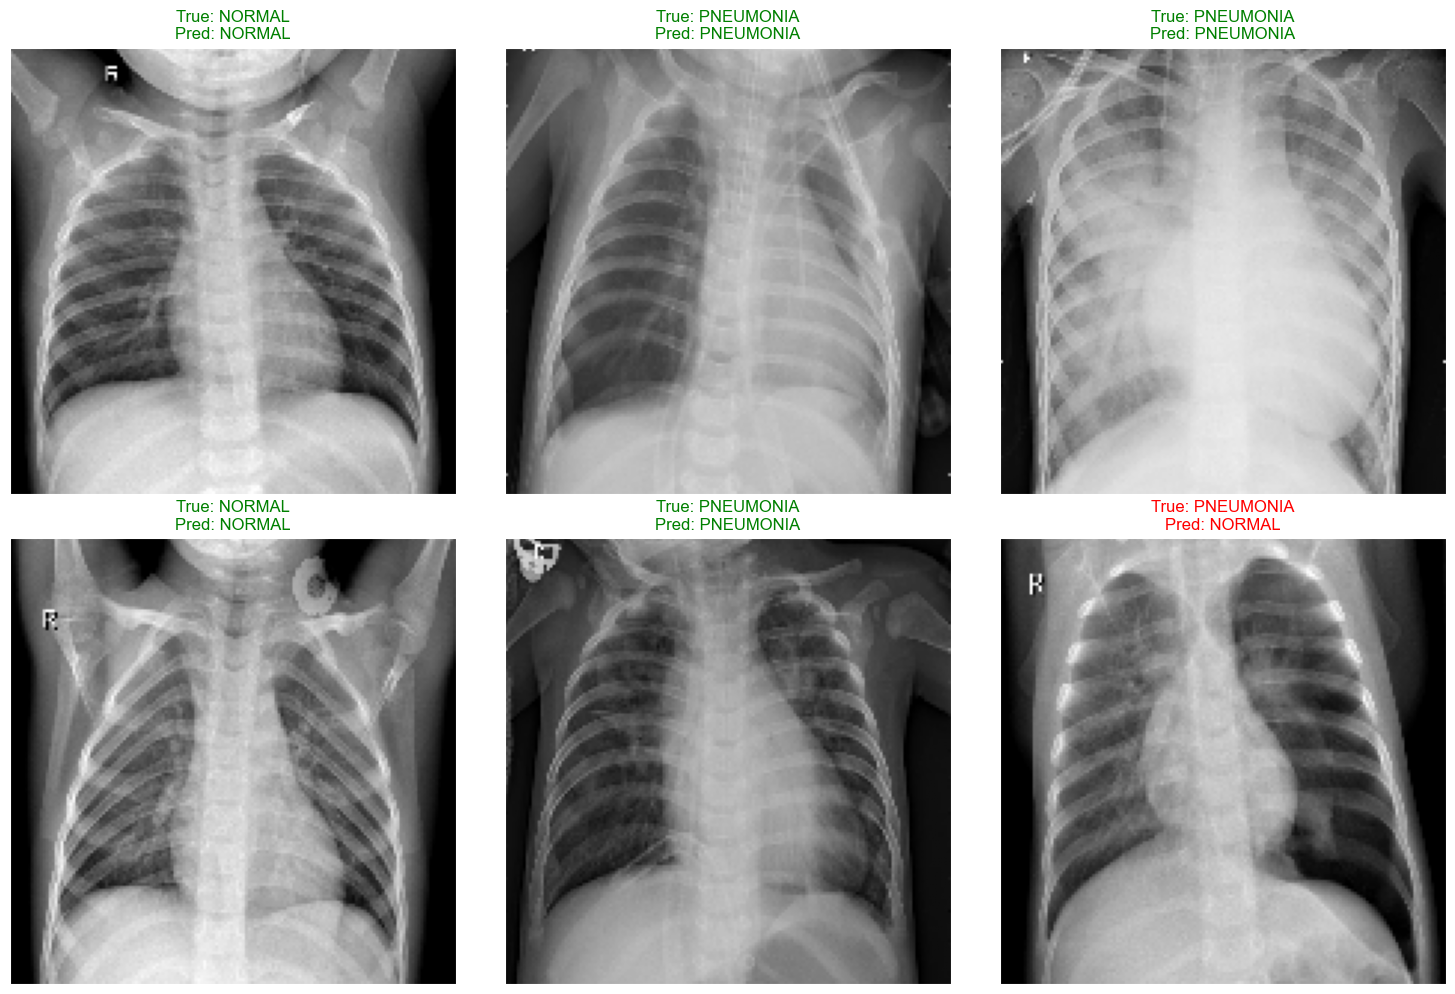

In [40]:
# Visualize some predictions
indices = np.random.choice(range(len(y_test)), 6, replace=False)
plt.figure(figsize=(15, 10))
for i, idx in enumerate(indices):
    plt.subplot(2, 3, i+1)
    img = x_test[idx].squeeze()
    plt.imshow(img, cmap='gray')
    color = 'green' if y_test[idx] == y_pred[idx] else 'red'
    true_label = 'PNEUMONIA' if y_test[idx] == 1 else 'NORMAL'
    pred_label = 'PNEUMONIA' if y_pred[idx] == 1 else 'NORMAL'
    plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()